### Algorithm for the analysis of the Medibio's ECG file set. 
### Measuring different metrics and clustering

###### written by Nicola Pastorello 5/11/2015

#### Notes:
 - The HB and accelerometer data are in terms of minutes. The minutes from noon are equal to 
     the indices of the arrays.
 - Awake and sleeping time are just conservative values (from the 3LF approach). 
     When used, it's better to add/subtract them 60 minutes (to include ONLY 
     real sleeping time).
     
 - Bhatthacharyya distance compares arrays with the SAME size
 
 - The Hjorth mobility and complexity together are able to somehow separate the different Stress labels
 
 - The Single Value Decomposition entropy does a good job in separating severe and mild stress levels (with moderate somehow in between). 
     

In [1]:
%matplotlib inline
#%matplotlib nbagg
# Loading libraries
import numpy as np
import pandas as pd
import datetime, pickle
import os, glob, sys
from pylab import *
from scipy import signal, misc

In [2]:
# Input
fileIn = open('totDF.dat', 'rb')
DF = pickle.load(fileIn)
fileIn.close()

### Example of data

moderate


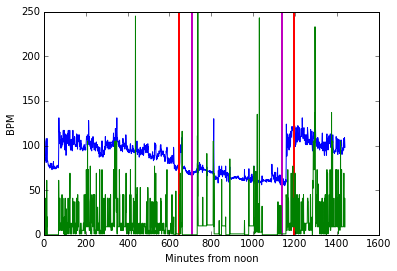

In [30]:
rowDF = 15
rowDF = np.random.choice(np.arange(len(DF)))
xx = np.arange(len(DF.ix[rowDF].HB))
figure(1)
plot(xx, DF.ix[rowDF].HB)
axvline(x=DF.ix[rowDF].Sleep, ymin=-30, ymax = 30, linewidth=2, color='r')
axvline(x=DF.ix[rowDF].Awake, ymin=-30, ymax = 30, linewidth=2, color='r')
axvline(x=DF.ix[rowDF].Sleep+60, ymin=-30, ymax = 30, linewidth=2, color='m')
axvline(x=DF.ix[rowDF].Awake-60, ymin=-30, ymax = 30, linewidth=2, color='m')

ylabel('BPM')
xlabel('Minutes from noon')
plot(xx, DF.ix[rowDF].acc)

print DF.ix[rowDF].Stress

(array([ 153.,  143.,  104.,  145.,  266.,  264.,  194.,   86.,   73.,   12.]),
 array([  62. ,   69.1,   76.2,   83.3,   90.4,   97.5,  104.6,  111.7,
         118.8,  125.9,  133. ]),
 <a list of 10 Patch objects>)

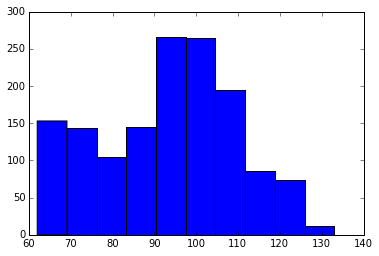

In [28]:
hist(DF.ix[rowDF].HB)

#### Bhattacharyya metric

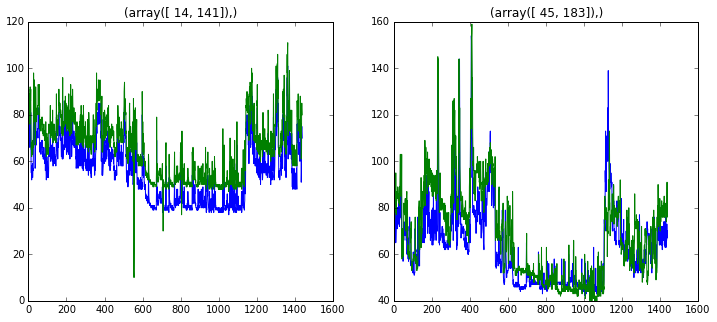

In [4]:
# Measuring Bhattacharyya metric in total and sleeping region
# This metric represents the distance between two histograms (or probability distributions).

def bhatta (array1, array2):  
    # Normalizing arrays
    array1 /= np.median(array1)
    array2 /= np.median(array2)
    #
    if len(array1) > len(array2): # Some arrays lack of the last value
        array1 = array1[:-1]
    elif len(array2) > len(array1):
        array2 = array2[:-1]
    # calculate mean of arrays
    h1_, h2_ = np.mean(array1), np.mean(array2)
    # calculate score
    dist = 0
    for ii in np.arange(len(array1)):
        dist += np.sqrt(array1[ii]*array2[ii])
    # 
    dist = np.sqrt(1.-(1./np.sqrt(h1_*h2_*len(array1)**2.))*dist)
    return dist


# Measuring Bhattacharyya distance between all the arrays (creating a matrix of distances)

if not(os.path.exists('BhattaTot.dat')):
    distBhatta_matrix = np.zeros((len(DF), len(DF)))
    print "Measuring Bhattacharyya distance. It will take some time."
    for ii in np.arange(len(DF)):
        for jj in np.arange(len(DF)-ii)+ii: 
            valueDist = bhatta(DF.ix[ii].HB, DF.ix[jj].HB)
            if np.isnan(valueDist): valueDist = 0.
            distBhatta_matrix[ii,jj] = valueDist
            distBhatta_matrix[jj,ii] = valueDist

    fileOut = open('BhattaTot.dat', 'wb')
    pickle.dump(distBhatta_matrix, fileOut)
    fileOut.close()

else:
    fileIn = open('BhattaTot.dat', 'rb')
    distBhatta_matrix = pickle.load(fileIn)
    fileIn.close()

# Clustering the arrays using the distance matrix
from scipy import cluster
from scipy.cluster import hierarchy as hier

# Converting the redundant distance matrix into a upper triangular matrix
ut_distBhatta_matrix = distBhatta_matrix[np.triu_indices(len(distBhatta_matrix),1)]

linkage_matrix = hier.linkage(ut_distBhatta_matrix, method='single')
# Sorting rows given the clusters
heatmapOrder = hier.leaves_list(linkage_matrix) 
orderedDataMatrix = distBhatta_matrix[heatmapOrder,:]

clusters = hier.fcluster(linkage_matrix, 0.2)


fig = figure(figsize=(12,5)); ax1, ax2 = subplot(121), subplot(122)
sel = np.where(clusters == 2)
ax1.set_title(sel)
ax1.plot(DF.ix[sel[0][0]].HB)
ax1.plot(DF.ix[sel[0][1]].HB+10)
sel = np.where(clusters == 1)
ax2.set_title(sel)
ax2.plot(DF.ix[sel[0][0]].HB)
ax2.plot(DF.ix[sel[0][1]].HB)

In [5]:
# Measuring, for each array, the Bhattacharyya distance between the sleeping 
# time profile and the linear fit

def bhattaSleep(array1, array2):    
    # Normalizing arrays
    array1 /= np.median(array1)
    array2 /= np.median(array2)
    #
    if len(array1) > len(array2): # Some arrays lack of the last value
        for ii in np.arange(len(array1)-len(array2)):
            array2 = np.append(array2, 1.)
    elif len(array2) > len(array1):
        for ii in np.arange(len(array2)-len(array1)):
            array1 = np.append(array1, 1.)
    # calculate mean of arrays
    h1_, h2_ = np.mean(array1), np.mean(array2)
    # calculate score
    dist = 0
    for ii in np.arange(len(array1)):
        dist += np.sqrt(array1[ii]*array2[ii])
    # 
    dist = np.sqrt(1.-(1./np.sqrt(h1_*h2_*len(array1)**2.))*dist)
    return dist


if not(os.path.exists('BhattaSleep.dat')):
    distBhatta_matrix = np.zeros((len(DF), len(DF)))
    print "Measuring Bhattacharyya distance. It will take some time."
    for ii in np.arange(len(DF)):
        xx_ii = np.arange(len(DF.ix[ii].HB))
        selSleep_ii = np.where((xx_ii>DF.ix[ii].Sleep+60) & 
                    (xx_ii<=DF.ix[ii].Awake-60))
        for jj in np.arange(len(DF)-ii)+ii: 
            xx_jj = np.arange(len(DF.ix[jj].HB))
            selSleep_jj = np.where((xx_jj>DF.ix[jj].Sleep+60) & 
                    (xx_jj<=DF.ix[jj].Awake-60))
            #
            valueDist = bhattaSleep(DF.ix[ii].HB[selSleep_ii], DF.ix[jj].HB[selSleep_jj])
            if np.isnan(valueDist): valueDist = 0.
            distBhatta_matrix[ii,jj] = valueDist
            distBhatta_matrix[jj,ii] = valueDist

    fileOut = open('BhattaSleep.dat', 'wb')
    pickle.dump(distBhatta_matrix, fileOut)
    fileOut.close()

else:
    fileIn = open('BhattaSleep.dat', 'rb')
    distBhatta_matrix = pickle.load(fileIn)
    fileIn.close()

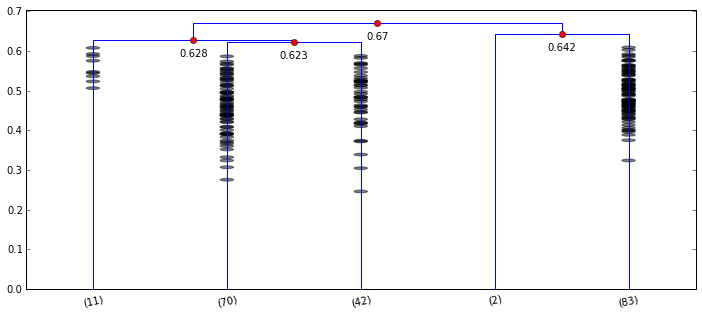

In [6]:
# Clustering the arrays using the distance matrix
from scipy import cluster
from scipy.cluster import hierarchy as hier

# Converting the redundant distance matrix into a upper triangular matrix
ut_distBhatta_matrix = distBhatta_matrix[np.triu_indices(len(distBhatta_matrix),0.55)]

linkage_matrix = hier.linkage(ut_distBhatta_matrix, method='average')
# Sorting rows given the clusters
heatmapOrder = hier.leaves_list(linkage_matrix) 
orderedDataMatrix = distBhatta_matrix[heatmapOrder,:]

# fig = figure(figsize=(12,5))
# sel = np.where(clusters == 5)
# clf(); ax1 = subplot(111)
# ax1.set_title(sel)
# for ii in sel[0]:
#     xx_ii = np.arange(len(DF.ix[ii].HB))
#     selSleep_ii = np.where((xx_ii>DF.ix[ii].Sleep+60) & 
#                     (xx_ii<=DF.ix[ii].Awake-60))
#     ax1.plot(np.arange(len(DF.ix[ii].HB))[selSleep_ii], DF.ix[ii].HB[selSleep_ii])


fig2 = figure(figsize=(12,5))
axD = subplot(111)

labels = []
colours = []
for ii in np.arange(len(DF)):
    labels.append(DF.ix[ii].Stress)
    if DF.ix[ii].Stress == 'moderate': colours.append('r')
    elif DF.ix[ii].Stress == 'mild': colours.append('g')
    elif DF.ix[ii].Stress == 'severe': colours.append('k')
    else: colours.append('b')

ddgram = hier.dendrogram(linkage_matrix, p=5, truncate_mode='lastp', 
                distance_sort=True, labels=labels, show_contracted=True, 
                ax = axD, color_threshold=0.5*ut_distBhatta_matrix.max())


for i, d in zip(ddgram['icoord'], ddgram['dcoord']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            plt.plot(x, y, 'ro')
            plt.annotate("%.3g" % y, (x, y), xytext=(0, -8),
                         textcoords='offset points',
                         va='top', ha='center')

" IT DOESN'T WORK (PERHAPS NOT A GOOD METRIC) "

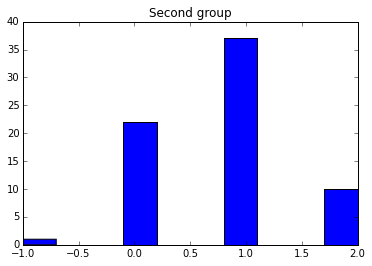

In [7]:
# Selecting the clusters that are split at  0.622   
clusters = hier.fcluster(linkage_matrix, 0.622, criterion='distance')

dicClusters = {}
for ii in np.arange(max(clusters))+1:
    dicClusters[str(ii)] = []

for ii in np.arange(len(clusters)):
    tmpList = dicClusters[str(clusters[ii])]
    if DF.ix[ii].Stress == 'mild': stress_value = 0
    elif DF.ix[ii].Stress == 'moderate': stress_value = 1
    elif DF.ix[ii].Stress == 'severe': stress_value = 2
    else: stress_value = -1
    tmpList.append(stress_value)
    dicClusters[str(clusters[ii])] = tmpList

hist(dicClusters['2'])
title('Second group')

# # Trying to see how many labels there are per cluster
# mild_tot, moderate_tot, severe_tot = [], [], []
# for ii in np.arange(np.max(clusters))+1:
#     tmpList = []
#     for jj in np.where(clusters == ii)[0]:
#         tmpList.append(DF.ix[jj].Stress) 
#     #
#     mild_tot.append(1.*tmpList.count('mild')/np.sqrt(len(tmpList)*1.))
#     moderate_tot.append(1.*tmpList.count('moderate')/np.sqrt(len(tmpList)*1.))
#     severe_tot.append(1.*tmpList.count('severe')/len(tmpList)*1.)

# # # Plot colorbar.
# # axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
# # pylab.colorbar(im, cax=axcolor)
# # fig.show()
''' IT DOESN'T WORK (PERHAPS NOT A GOOD METRIC) '''

#### Gini metric

In [8]:
# Measuring Gini coefficient in de-trended sleeping region

def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2
    return (fair_area - area) / fair_area


GiniP_trended, GiniP_detrended = [], [] 
for ii in np.arange(len(DF)):
    
    xx_ii = np.arange(len(DF.ix[ii].HB))
    selSleep_ii = np.where((xx_ii>DF.ix[ii].Sleep+60) & 
                            (xx_ii<=DF.ix[ii].Awake-60))
    
    Gt1, Gp1 = gini(DF.ix[ii].HB), gini(DF.ix[ii].HB[selSleep_ii])
    yy_ii = xx_ii*DF.ix[ii].Slope + DF.ix[ii].intercept
    
    Gt2, Gp2 = gini(DF.ix[ii].HB/(yy_ii)), gini(DF.ix[ii].HB[selSleep_ii]/(yy_ii[selSleep_ii]))
    
    GiniP_trended.append(Gp1)
    GiniP_detrended.append(Gp2)
    
#     plt.ioff()
#     fig = figure(num=0, figsize=(6,10)); clf()
#     ax1, ax2 = subplot(211), subplot(212)
    
#     ax1.plot(xx_ii, DF.ix[ii].HB)
#     ax1.plot(xx_ii[selSleep_ii], DF.ix[ii].HB[selSleep_ii])
    
#     ax1.plot(xx_ii, yy_ii)
#     ax1.set_title(r'$\rm{Gini_{tot}}=$'+str(round(Gt1, 3))+'\t'+
#                   r'$\rm{Gini_{sleep}}=$'+str(round(Gp1, 3)))
#     # # Detrend sleeping profile
#     ax2.plot(xx_ii, DF.ix[ii].HB/(yy_ii), c='b')
#     ax2.plot(xx_ii[selSleep_ii], DF.ix[ii].HB[selSleep_ii]/(yy_ii[selSleep_ii]), c='g')
    
    
#     ax2.set_title(r'$\rm{Gini_{tot}}=$'+str(round(Gt2, 3))+'\t'+
#                   r'$\rm{Gini_{sleep}}=$'+str(round(Gp2, 3)))
    
    

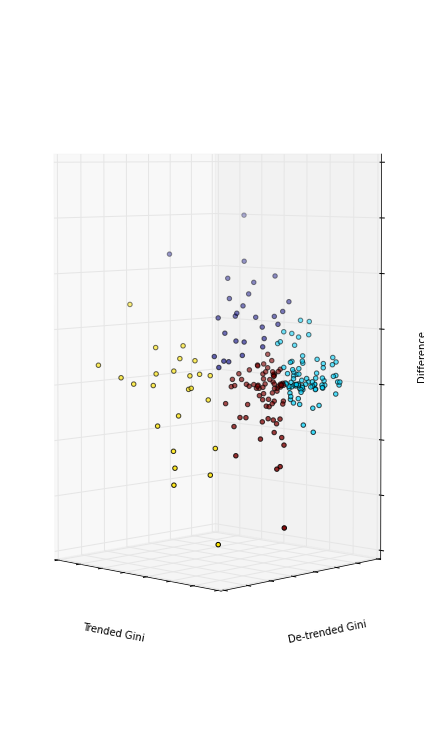

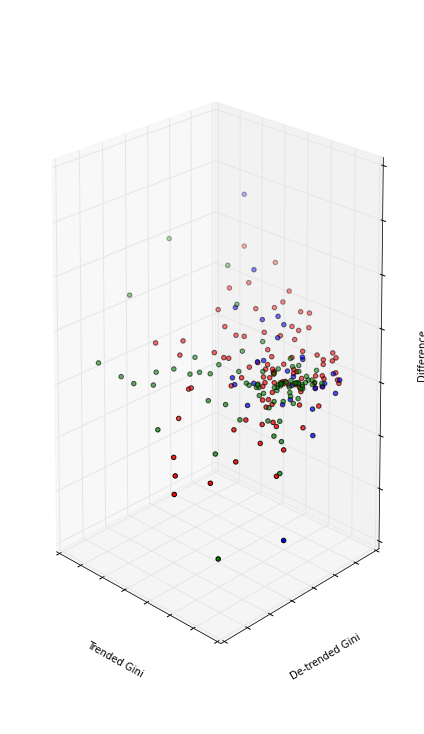

In [9]:
# Clustering with Gini coefficient in the de-trended sleeping region
import sklearn
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(5)

X = np.column_stack((GiniP_trended, GiniP_detrended, 
                     np.array(GiniP_trended)-np.array(GiniP_detrended)))
y = np.array(DF.Stress) # Target classification


estimators = {#'k_means_2': KMeans(n_clusters=2),
             'k_means_4': KMeans(n_clusters=4, n_init=10,init='random')
 
# Not useful
#                'MeanShift': sklearn.cluster.MeanShift()
#               'AP': sklearn.cluster.AffinityPropagation()
#                 'Spectral': sklearn.cluster.SpectralClustering(n_clusters=4)
    
# Not working
#               'Birch': sklearn.cluster.Birch()
#              'DBSCAN': sklearn.cluster.DBSCAN()
#                'FA': sklearn.cluster.FeatureAgglomeration(n_clusters=4)
             }

name, est = estimators.items()[0]
fig = plt.figure(figsize=(6, 10))
axTmp = Axes3D(fig, rect=[0, 0, .95, 1], elev=3, azim=134)

est.fit(X)
labels = est.labels_

axTmp.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels.astype(np.float))
    
axTmp.w_xaxis.set_ticklabels([])
axTmp.w_yaxis.set_ticklabels([])
axTmp.w_zaxis.set_ticklabels([])
axTmp.set_xlabel('Trended Gini')
axTmp.set_ylabel('De-trended Gini')
axTmp.set_zlabel('Difference')


# Plot the ground truth

fig = plt.figure(figsize=(6, 10))
axReal = Axes3D(fig, rect=[0, 0, .95, 1], elev=15, azim=134)

selModerate = np.where(y == 'moderate')
selSevere = np.where(y == 'severe')
selMild = np.where(y == 'mild')  
axReal.scatter(X[:, 0][selModerate], X[:, 1][selModerate], X[:, 2][selModerate], c='r')
axReal.scatter(X[:, 0][selSevere], X[:, 1][selSevere], X[:, 2][selSevere], c='b')
axReal.scatter(X[:, 0][selMild], X[:, 1][selMild], X[:, 2][selMild], c='g')

axReal.w_xaxis.set_ticklabels([])
axReal.w_yaxis.set_ticklabels([])
axReal.w_zaxis.set_ticklabels([])
axReal.set_xlabel('Trended Gini')
axReal.set_ylabel('De-trended Gini')
axReal.set_zlabel('Difference')


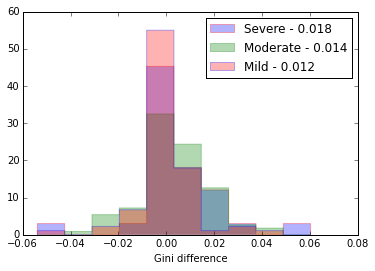

In [10]:
# Histogram of Gini differences
fig2 = figure()
ax = subplot(111)

# Checking differences between Gini coefficients on different scales
mod, sev, mild = (X[:, 0][selModerate]- X[:, 1][selModerate], 
                  X[:, 0][selSevere]- X[:, 1][selSevere],
                  X[:, 0][selMild]- X[:, 1][selMild]) 

n, bins, patches = ax.hist([mild, mod, sev], histtype='step', normed=1, fill=True, alpha=0.3,
        label=['Mild - '+str(round(std(mild),3)), 
               'Moderate - '+str(round(std(mod),3)),
               'Severe - '+str(round(std(sev),3))])
ax.legend()
ax.set_xlabel('Gini difference')

In [11]:
# Measuring Gini coefficient in de-trended sleeping region on different scales

# for each profile a number of metrics obtained by averaging the Gini coefficient 
# in all the consequtive bins with the same size. Different metrics come from different bin sizes.

#### Entropy metrics

In [12]:
# Measuring approximate entropy in total and sleeping region
from pyeeg import *

entropy_total, entropy_sleep = [], []

for ii in np.arange(len(DF)):
    print ii,'/',len(DF)
    xx_ii = np.arange(len(DF.ix[ii].HB))
    selSleep_ii = np.where((xx_ii>DF.ix[ii].Sleep+60) & 
                      (xx_ii<=DF.ix[ii].Awake-60))
    HB_ii = DF.ix[ii]['HB']
    HB_ii_sel = HB_ii[selSleep_ii]
    
    m = 15 # smoothing time frame to compare the entropy at
    r = np.std(DF.ix[ii].HB)/4. # tolerance (20-30% of Signal STD)

    entropy_total.append(ap_entropy(HB_ii, m, r))
    entropy_sleep.append(ap_entropy(HB_ii_sel, m, r))

0 / 208
1 / 208
2 / 208
3 / 208
4 / 208
5 / 208
6 / 208
7 / 208
8 / 208
9 / 208
10 / 208
11 / 208
12 / 208
13 / 208
14 / 208
15 / 208
16 / 208
17 / 208
18 / 208
19 / 208
20 / 208
21 / 208
22 / 208
23 / 208
24 / 208
25 / 208
26 / 208
27 / 208
28 / 208
29 / 208
30 / 208
31 / 208
32 / 208
33 / 208
34 / 208
35 / 208
36 / 208
37 / 208
38 / 208
39 / 208
40 / 208
41 / 208
42 / 208
43 / 208
44 / 208
45 / 208
46 / 208
47 / 208
48 / 208
49 / 208
50 / 208
51 / 208
52 / 208
53 / 208
54 / 208
55 / 208
56 / 208
57 / 208
58 / 208
59 / 208
60 / 208
61 / 208
62 / 208
63 / 208
64 / 208
65 / 208
66 / 208
67 / 208
68 / 208
69 / 208
70 / 208
71 / 208
72 / 208
73 / 208
74 / 208
75 / 208
76 / 208
77 / 208
78 / 208
79 / 208
80 / 208
81 / 208
82 / 208
83 / 208
84 / 208
85 / 208
86 / 208
87 / 208
88 / 208
89 / 208
90 / 208
91 / 208
92 / 208
93 / 208
94 / 208
95 / 208
96 / 208
97 / 208
98 / 208
99 / 208
100 / 208
101 / 208
102 / 208
103 / 208
104 / 208
105 / 208
106 / 208
107 / 208
108 / 208
109 / 208
110 / 208


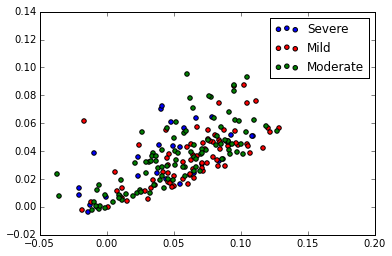

In [13]:
figure()
entropy_sleep, entropy_total = np.array(entropy_sleep), np.array(entropy_total)
selModerate = np.where(y == 'moderate')
selSevere = np.where(y == 'severe')
selMild = np.where(y == 'mild')  
scatter(entropy_sleep[selSevere], entropy_total[selSevere], c='b', label='Severe')
scatter(entropy_sleep[selMild], entropy_total[selMild], c='r', label='Mild')
scatter(entropy_sleep[selModerate], entropy_total[selModerate], c='g', label='Moderate')
legend()

In [14]:
# Single Value Decomposition entropy (measures feature-richness in the sense that the higher the 
# entropy of the set of SVD weights, the more orthogonal vectors are required to 
# adequately explain it )
from pyeeg import svd_entropy, embed_seq
SVD_2, SVD_3 = [], []
SVD_5, SVD_10, SVD_15 = [], [], []
SVD_20, SVD_25, SVD_30 = [], [], []
for ii in np.arange(len(DF)):
    xx_ii = np.arange(len(DF.ix[ii].HB))
    selSleep_ii = np.where((xx_ii>DF.ix[ii].Sleep+60) & 
                      (xx_ii<=DF.ix[ii].Awake-60))
    HB_ii = DF.ix[ii]['HB'] 

    Tau = 1
    
    SVD_2.append(svd_entropy(HB_ii[selSleep_ii], Tau, 2))
    SVD_3.append(svd_entropy(HB_ii[selSleep_ii], Tau, 3))
    SVD_5.append(svd_entropy(HB_ii[selSleep_ii], Tau, 5))
    SVD_10.append(svd_entropy(HB_ii[selSleep_ii], Tau, 10))
    SVD_15.append(svd_entropy(HB_ii[selSleep_ii], Tau, 15))
    SVD_20.append(svd_entropy(HB_ii[selSleep_ii], Tau, 20))
    SVD_25.append(svd_entropy(HB_ii[selSleep_ii], Tau, 25))
    SVD_30.append(svd_entropy(HB_ii[selSleep_ii], Tau, 30))

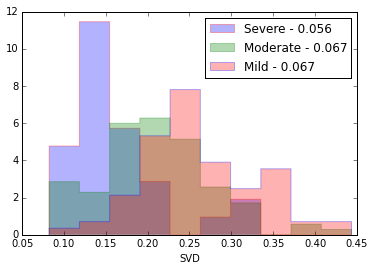

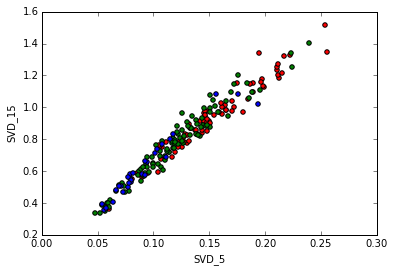

In [15]:
SVD_2, SVD_3 = np.array(SVD_2), np.array(SVD_3)
SVD_5, SVD_10, SVD_15 = np.array(SVD_2), np.array(SVD_10), np.array(SVD_15)
SVD_20, SVD_25, SVD_30 = np.array(SVD_20), np.array(SVD_25), np.array(SVD_30),
selModerate = np.where(DF.Stress == 'moderate')
selSevere = np.where(DF.Stress == 'severe')
selMild = np.where(DF.Stress == 'mild')  

figure()
ax = subplot(111)
mod, sev, mild = (SVD_3[selModerate], SVD_3[selSevere], SVD_3[selMild])
n, bins, patches = ax.hist([mild, mod, sev], histtype='step', normed=1, fill=True, alpha=0.3,
        label=['Mild - '+str(round(std(mild),3)), 
               'Moderate - '+str(round(std(mod),3)),
               'Severe - '+str(round(std(sev),3))])
ax.set_xlabel('SVD')
ax.legend()


figure()
ax = subplot(111)
ax.scatter(SVD_5[selMild], SVD_15[selMild], c='r')
ax.scatter(SVD_5[selModerate], SVD_15[selModerate], c='g')
ax.scatter(SVD_5[selSevere], SVD_15[selSevere], c='b')
ax.set_xlabel('SVD_5'); ax.set_ylabel('SVD_15')
show()

#### Fractal metrics

In [16]:
# Petrosian and Hjorth Fractal dimensions on de-trended sleep regions
from pyeeg import *
Petrosian, Hjorth = [], []

for ii in np.arange(len(DF)):
    xx_ii = np.arange(len(DF.ix[ii].HB))
    selSleep_ii = np.where((xx_ii>DF.ix[ii].Sleep+60) & 
                      (xx_ii<=DF.ix[ii].Awake-60))
    HB_ii = DF.ix[ii]['HB']
    HB_ii_sel = HB_ii[selSleep_ii]
    yy_ii = xx_ii*DF.ix[ii].Slope + DF.ix[ii].intercept
    HB_ii_sel_detrended = (HB_ii/yy_ii)[selSleep_ii]

#     Petrosian.append(pfd(HB_ii_sel))
#     Hjorth.append(hfd(HB_ii_sel, 15))
    Petrosian.append(pfd(HB_ii_sel_detrended))
    Hjorth.append(hfd(HB_ii_sel_detrended, 15))

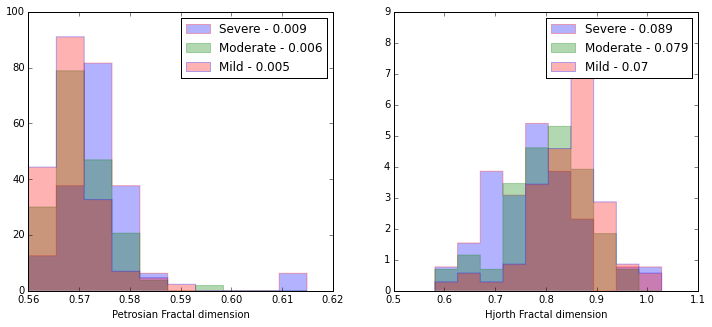

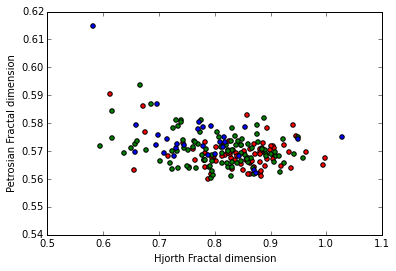

In [17]:
Petrosian, Hjorth = np.array(Petrosian), np.array(Hjorth)
selModerate = np.where(DF.Stress == 'moderate')
selSevere = np.where(DF.Stress == 'severe')
selMild = np.where(DF.Stress == 'mild')  

figure(figsize=(12, 5))
ax = subplot(121)
mod, sev, mild = (Petrosian[selModerate], Petrosian[selSevere], Petrosian[selMild])
n, bins, patches = ax.hist([mild, mod, sev], histtype='step', normed=1, fill=True, alpha=0.3,
        label=['Mild - '+str(round(std(mild),3)), 
               'Moderate - '+str(round(std(mod),3)),
               'Severe - '+str(round(std(sev),3))])
ax.set_xlabel('Petrosian Fractal dimension')
ax.legend()

ax2 = subplot(122)
mod, sev, mild = (Hjorth[selModerate], Hjorth[selSevere], Hjorth[selMild])
n, bins, patches = ax2.hist([mild, mod, sev], histtype='step', normed=1, fill=True, alpha=0.3,
        label=['Mild - '+str(round(std(mild),3)), 
               'Moderate - '+str(round(std(mod),3)),
               'Severe - '+str(round(std(sev),3))])
ax2.set_xlabel('Hjorth Fractal dimension')
ax2.legend()

figure()
ax = subplot(111)
ax.scatter(Hjorth[selMild], Petrosian[selMild], c='r')
ax.scatter(Hjorth[selModerate], Petrosian[selModerate], c='g')
ax.scatter(Hjorth[selSevere], Petrosian[selSevere], c='b')
ax.set_xlabel('Hjorth Fractal dimension'); ax.set_ylabel('Petrosian Fractal dimension')
show()

In [18]:
# Hurst exponent (the higher, the less fractal/rough the profile)
from pyeeg import *
hurstExponent = []
for ii in np.arange(len(DF)):
    xx_ii = np.arange(len(DF.ix[ii].HB))
    selSleep_ii = np.where((xx_ii>DF.ix[ii].Sleep+60) & 
                  (xx_ii<=DF.ix[ii].Awake-60))
    HB_ii = DF.ix[ii]['HB']
    HB_ii_sel = HB_ii[selSleep_ii]
    yy_ii = xx_ii*DF.ix[ii].Slope + DF.ix[ii].intercept
    HB_ii_sel_detrended = (HB_ii/yy_ii)[selSleep_ii]

    hurstExponent.append(hurst(HB_ii_sel_detrended))

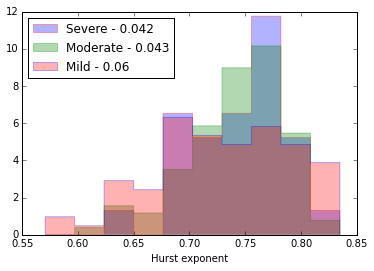

In [19]:
hurstExponent = np.array(hurstExponent)
selModerate = np.where((DF.Stress == 'moderate') & ~np.isnan(hurstExponent))
selSevere = np.where((DF.Stress == 'severe') & ~np.isnan(hurstExponent))
selMild = np.where((DF.Stress == 'mild') & ~np.isnan(hurstExponent))

figure()
ax = subplot(111)
mod, sev, mild = (hurstExponent[selModerate], hurstExponent[selSevere], hurstExponent[selMild])

n, bins, patches = ax.hist([mild, mod, sev], histtype='step', normed=1, fill=True, alpha=0.3,
        label=['Mild - '+str(round(std(mild),3)), 
               'Moderate - '+str(round(std(mod),3)),
               'Severe - '+str(round(std(sev),3))])
ax.set_xlabel('Hurst exponent')
ax.legend(loc=2)

# figure()
# ax = subplot(111)
# ax.scatter(hurstExponent[selMild], something[selMild], c='r', label='Mild')
# ax.scatter(hurstExponent[selModerate], something[selMild],  c='g', label='Moderate')
# ax.scatter(hurstExponent[selSevere], something[selMild], c='b', label='Severe')
# ax.set_xlabel(r'Hurst exponent')#; ax.set_ylabel(r'$\log_{10}(\rm{Hjorth\ mobility})$')
# # ax.set_xlim([80,600])
# #ax.set_ylim([0,0.012])
# legend()
# show()

In [20]:
# Detrended Fluctuation analysis
# check tutorial here: http://localhost:8888/notebooks/mdfaintro.ipynb
# The closer the result to 0.5, the closer to white noise the profile

from pyeeg import *

DFA_tot, DFA_sel, DFA_sel_detrended = [], [], []

# windowSize = [5,10,15,20,25,50,100,200,300]
def getWindowSize(inputArray):
    ll = len(inputArray)
    return np.logspace(np.log2(ll/5.),np.log2(ll-50.),num=20,base=2.)

for ii in np.arange(len(DF)):
    xx_ii = np.arange(len(DF.ix[ii].HB))
    selSleep_ii = np.where((xx_ii>DF.ix[ii].Sleep+60) &
              (xx_ii<=DF.ix[ii].Awake-60))
    HB_ii = DF.ix[ii]['HB']
    HB_ii_sel = HB_ii[selSleep_ii]
    
    DFA_tot.append(dfa(HB_ii, L=getWindowSize(HB_ii)))
    DFA_sel.append(dfa(HB_ii_sel, L=getWindowSize(HB_ii_sel)))#,10,15,20,25,50,100,200,300]))
    
    yy_ii = xx_ii*DF.ix[ii].Slope + DF.ix[ii].intercept
    HB_ii_sel_detrended = (HB_ii/yy_ii)[selSleep_ii]
    
    DFA_sel_detrended.append(dfa(HB_ii_sel_detrended, L=getWindowSize(HB_ii_sel_detrended)))#,10,15,20,25,50,100,200,300]))
    


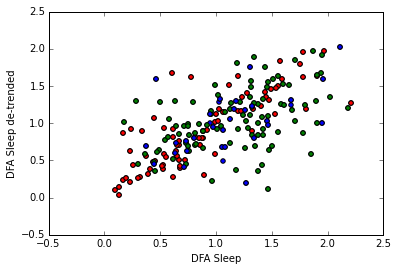

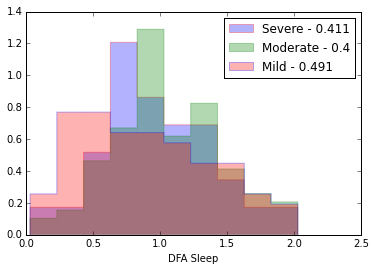

In [21]:
DFA_sel_detrended, DFA_sel, DFA_tot = np.array(DFA_sel_detrended), np.array(DFA_sel), np.array(DFA_tot)

plt.ion()
figure()
clf()
ax = subplot(111)
scatter(DFA_sel, DFA_sel_detrended)

selModerate = np.where((DF.Stress == 'moderate')  & ~np.isnan(DFA_sel_detrended))
selSevere = np.where((DF.Stress == 'severe') & ~np.isnan(DFA_sel_detrended))
selMild = np.where((DF.Stress == 'mild') & ~np.isnan(DFA_sel_detrended))

ax.scatter(DFA_sel[selMild], DFA_sel_detrended[selMild], c='r', label='Mild')
ax.scatter(DFA_sel[selModerate], DFA_sel_detrended[selModerate],  c='g', label='Moderate')
ax.scatter(DFA_sel[selSevere], DFA_sel_detrended[selSevere], c='b', label='Severe')
ax.set_xlabel('DFA Sleep'); ax.set_ylabel('DFA Sleep de-trended') 
#ax.plot([.4,1.8],[.4, 1.8], 'k--')
#ax.plot([-.4,0],[-.4, 0], 'k--')

figure()
ax = subplot(111)
mod, sev, mild = (DFA_sel_detrended[selModerate], DFA_sel_detrended[selSevere], DFA_sel_detrended[selMild])

n, bins, patches = ax.hist([mild, mod, sev], histtype='step', normed=1, fill=True, alpha=0.3,
        label=['Mild - '+str(round(std(mild),3)), 
               'Moderate - '+str(round(std(mod),3)),
               'Severe - '+str(round(std(sev),3))])
ax.set_xlabel('DFA Sleep')
ax.legend(loc=1)

### Other metrics

In [22]:
# Hjorth mobility and complexity 
from pyeeg import *
H_mobility, H_complexity = [], []
for ii in np.arange(len(DF)):
    xx_ii = np.arange(len(DF.ix[ii].HB))
    selSleep_ii = np.where((xx_ii>DF.ix[ii].Sleep+60) &
                  (xx_ii<=DF.ix[ii].Awake-60))
    HB_ii = DF.ix[ii]['HB']
    HB_ii_sel = HB_ii[selSleep_ii]
    #
    yy_ii = xx_ii*DF.ix[ii].Slope + DF.ix[ii].intercept
    HB_ii_sel_detrended = (HB_ii/yy_ii)[selSleep_ii]
    
    H_mobility.append(hjorth(HB_ii_sel)[0])
    H_complexity.append(hjorth(HB_ii_sel)[1])    

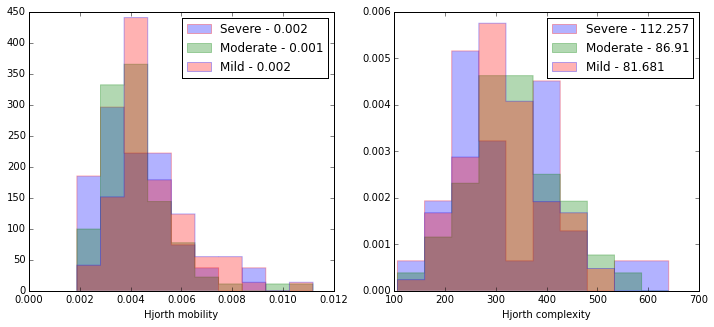

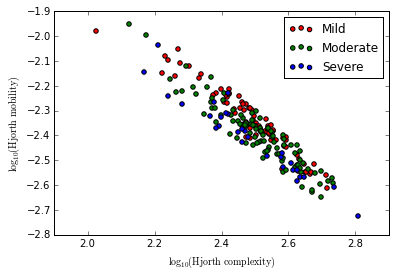

In [23]:
H_mobility, H_complexity = np.array(H_mobility), np.array(H_complexity)
selModerate = np.where(DF.Stress == 'moderate')
selSevere = np.where(DF.Stress == 'severe')
selMild = np.where(DF.Stress == 'mild')  

figure(figsize=(12, 5))
ax = subplot(121)
mod, sev, mild = (H_mobility[selModerate], H_mobility[selSevere], H_mobility[selMild])
n, bins, patches = ax.hist([mild, mod, sev], histtype='step', normed=1, fill=True, alpha=0.3,
        label=['Mild - '+str(round(std(mild),3)), 
               'Moderate - '+str(round(std(mod),3)),
               'Severe - '+str(round(std(sev),3))])
ax.set_xlabel('Hjorth mobility')
ax.legend()

ax2 = subplot(122)
mod, sev, mild = (H_complexity[selModerate], H_complexity[selSevere], H_complexity[selMild])
n, bins, patches = ax2.hist([mild, mod, sev], histtype='step', normed=1, fill=True, alpha=0.3,
        label=['Mild - '+str(round(std(mild),3)), 
               'Moderate - '+str(round(std(mod),3)),
               'Severe - '+str(round(std(sev),3))])
ax2.set_xlabel('Hjorth complexity')
ax2.legend()

figure()
ax = subplot(111)
# ax.scatter(H_complexity[selMild], H_mobility[selMild], c='r', label='Mild')
# ax.scatter(H_complexity[selModerate], H_mobility[selModerate], c='g', label='Moderate')
# ax.scatter(H_complexity[selSevere], H_mobility[selSevere], c='b', label='Severe')
# ax.set_xlabel('H_complexity'); ax.set_ylabel('H_mobility')
# ax.set_xlim([80,600])
# ax.set_ylim([0,0.012])
ax.scatter(np.log10(H_complexity[selMild]), np.log10(H_mobility[selMild]), c='r', label='Mild')
ax.scatter(np.log10(H_complexity[selModerate]), np.log10(H_mobility[selModerate]), c='g', label='Moderate')
ax.scatter(np.log10(H_complexity[selSevere]), np.log10(H_mobility[selSevere]), c='b', label='Severe')
ax.set_xlabel(r'$\log_{10}(\rm{Hjorth\ complexity})$'); ax.set_ylabel(r'$\log_{10}(\rm{Hjorth\ mobility})$')
# ax.set_xlim([80,600])
#ax.set_ylim([0,0.012])
legend()
show()

In [24]:
# Measuring frequency domain features
# The idea is to measure the scatter of the Fourier Transform
FT_std = []
ff = []
for ii in np.arange(len(DF)):
    xx_ii = np.arange(len(DF.ix[ii].HB))
    selSleep_ii = np.where((xx_ii>DF.ix[ii].Sleep+60) &
              (xx_ii<=DF.ix[ii].Awake-60))
    HB_ii = DF.ix[ii]['HB']
    HB_ii_sel = HB_ii[selSleep_ii]
    
    #
    yy_ii = xx_ii*DF.ix[ii].Slope + DF.ix[ii].intercept
    HB_ii_sel_detrended = (HB_ii/yy_ii)[selSleep_ii]

    sp = np.fft.fft(HB_ii_sel_detrended)
    freq = np.fft.fftfreq(HB_ii_sel_detrended.shape[-1], d = 1.) # time sloth of histogram is 1 hour
#     plt.plot(freq, np.log10(sp))#np.log10(np.abs(sp) ** 2))
#     plt.show()
    FT_std.append(std(np.log10(np.abs(sp)[np.where(freq>0)])))
    ff.append(np.log10(sp)[np.where(freq>0)])

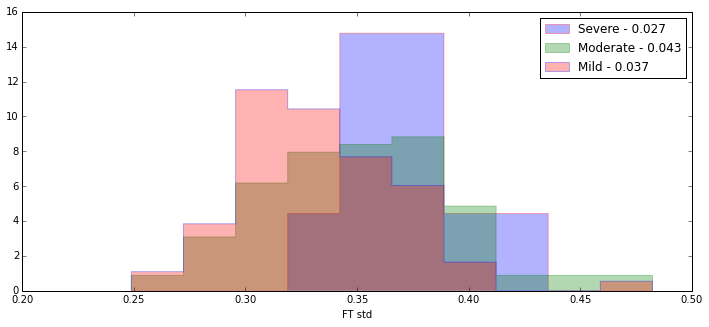

In [25]:
FT_std = np.array(FT_std)
selModerate = np.where(DF.Stress == 'moderate')
selSevere = np.where(DF.Stress == 'severe')
selMild = np.where(DF.Stress == 'mild')  

figure(figsize=(12, 5))
ax = subplot(111)
mod, sev, mild = (FT_std[selModerate], FT_std[selSevere], FT_std[selMild])
n, bins, patches = ax.hist([mild, mod, sev], histtype='step', normed=1, fill=True, alpha=0.3,
        label=['Mild - '+str(round(std(mild),3)), 
               'Moderate - '+str(round(std(mod),3)),
               'Severe - '+str(round(std(sev),3))])
ax.set_xlabel('FT std')
ax.legend()

In [26]:
# Measuring std in de-trended sleeping profile
std_detrended = []

for ii in np.arange(len(DF)):
    xx_ii = np.arange(len(DF.ix[ii].HB))
    selSleep_ii = np.where((xx_ii>DF.ix[ii].Sleep+60) &
              (xx_ii<=DF.ix[ii].Awake-60))
    HB_ii = DF.ix[ii]['HB']
    HB_ii_sel = HB_ii[selSleep_ii]
    
    #
    yy_ii = xx_ii*DF.ix[ii].Slope + DF.ix[ii].intercept
    HB_ii_sel_detrended = (HB_ii/yy_ii)[selSleep_ii]

    std_detrended.append(std(HB_ii_sel_detrended))

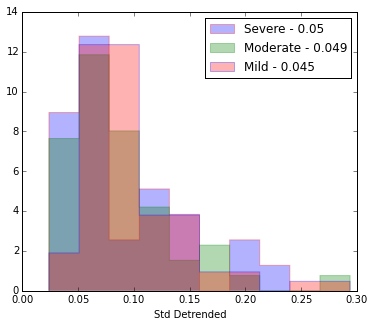

In [27]:
std_detrended = np.array(std_detrended)
selModerate = np.where(DF.Stress == 'moderate')
selSevere = np.where(DF.Stress == 'severe')
selMild = np.where(DF.Stress == 'mild')  

figure(figsize=(6, 5))
ax = subplot(111)
mod, sev, mild = (std_detrended[selModerate], std_detrended[selSevere], std_detrended[selMild])
n, bins, patches = ax.hist([mild, mod, sev], histtype='step', normed=1, fill=True, alpha=0.3,
        label=['Mild - '+str(round(std(mild),3)), 
               'Moderate - '+str(round(std(mod),3)),
               'Severe - '+str(round(std(sev),3))])
ax.set_xlabel('Std Detrended')
ax.legend()

In [28]:
# Measuring average and median HB 
average_HB = []
median_HB = []

for ii in np.arange(len(DF)):
    xx_ii = np.arange(len(DF.ix[ii].HB))
    selSleep_ii = np.where((xx_ii>DF.ix[ii].Sleep+60) &
              (xx_ii<=DF.ix[ii].Awake-60))
    HB_ii = DF.ix[ii]['HB']
    HB_ii_sel = HB_ii[selSleep_ii]
    
    #
    average_HB.append(np.average(HB_ii_sel))
    median_HB.append(np.median(HB_ii_sel))

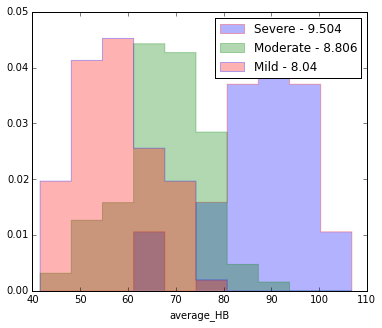

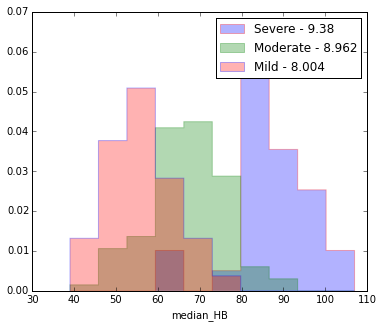

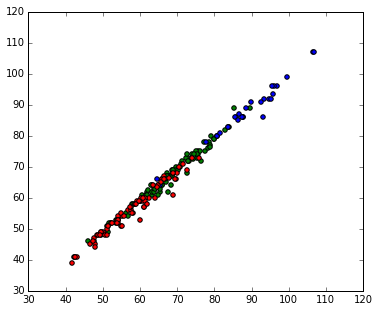

In [29]:
average_HB = np.array(average_HB)
median_HB = np.array(median_HB)
selModerate = np.where(DF.Stress == 'moderate')
selSevere = np.where(DF.Stress == 'severe')
selMild = np.where(DF.Stress == 'mild')  

figure(figsize=(6, 5))
ax = subplot(111)
mod, sev, mild = (average_HB[selModerate], average_HB[selSevere], average_HB[selMild])
n, bins, patches = ax.hist([mild, mod, sev], histtype='step', normed=1, fill=True, alpha=0.3,
        label=['Mild - '+str(round(std(mild),3)), 
               'Moderate - '+str(round(std(mod),3)),
               'Severe - '+str(round(std(sev),3))])
ax.set_xlabel('average_HB')
ax.legend()


figure(figsize=(6, 5))
ax = subplot(111)
mod, sev, mild = (median_HB[selModerate], median_HB[selSevere], median_HB[selMild])
n, bins, patches = ax.hist([mild, mod, sev], histtype='step', normed=1, fill=True, alpha=0.3,
        label=['Mild - '+str(round(std(mild),3)), 
               'Moderate - '+str(round(std(mod),3)),
               'Severe - '+str(round(std(sev),3))])
ax.set_xlabel('median_HB')
ax.legend()


figure(figsize=(6, 5))
ax = subplot(111)
ax.scatter(average_HB[selModerate], median_HB[selModerate], c='g')
ax.scatter(average_HB[selSevere], median_HB[selSevere], c='b')
ax.scatter(average_HB[selMild], median_HB[selMild], c='r')

In [30]:
# Measuring total sleeping time
sleepingTime = []

for ii in np.arange(len(DF)):
    xx_ii = np.arange(len(DF.ix[ii].HB))
    selSleep_ii = np.where((xx_ii>DF.ix[ii].Sleep+60) &
              (xx_ii<=DF.ix[ii].Awake-60))
    HB_ii = DF.ix[ii]['HB']
    HB_ii_sel = HB_ii[selSleep_ii]
    
    #
    sleepingTime.append(len(selSleep_ii[0]))

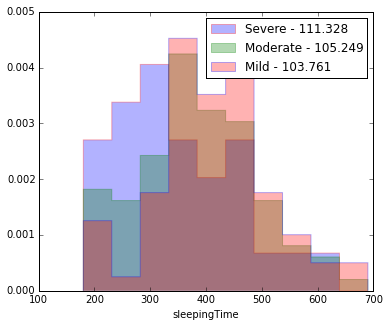

In [31]:
sleepingTime = np.array(sleepingTime)
selModerate = np.where(DF.Stress == 'moderate')
selSevere = np.where(DF.Stress == 'severe')
selMild = np.where(DF.Stress == 'mild')  

figure(figsize=(6, 5))
ax = subplot(111)
mod, sev, mild = (sleepingTime[selModerate], sleepingTime[selSevere], sleepingTime[selMild])
n, bins, patches = ax.hist([mild, mod, sev], histtype='step', normed=1, fill=True, alpha=0.3,
        label=['Mild - '+str(round(std(mild),3)), 
               'Moderate - '+str(round(std(mod),3)),
               'Severe - '+str(round(std(sev),3))])
ax.set_xlabel('sleepingTime')
ax.legend()



In [59]:
# Measuring accelerometer STD during the sleeping region
accSTD, medianSTD = [], []
for ii in np.arange(len(DF)):
    xx_ii = np.arange(len(DF.ix[ii].HB))
    selSleep_ii = np.where((xx_ii>DF.ix[ii].Sleep+60) &
              (xx_ii<=DF.ix[ii].Awake-60))
    acc_ii = DF.ix[ii].acc
    acc_ii_sel = acc_ii[selSleep_ii]
    
    if std(acc_ii_sel) != 0:
        accSTD.append(std(acc_ii_sel))
        medianSTD.append(np.median(acc_ii_sel))
    else:
        accSTD.append(100)
        medianSTD.append(100)

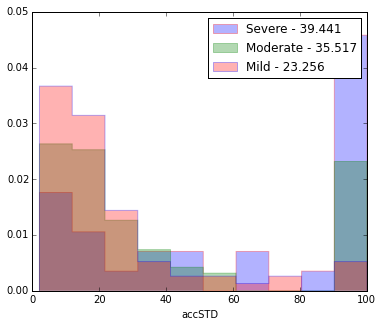

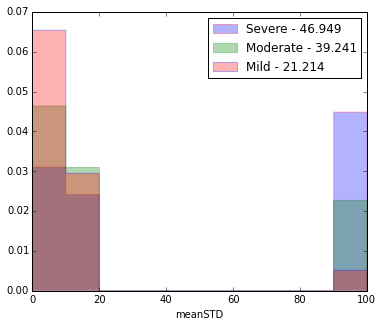

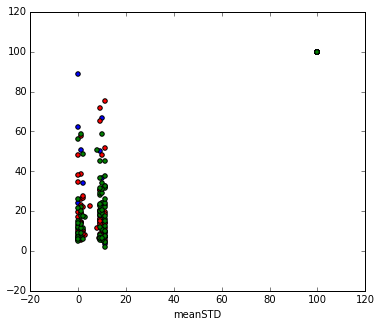

In [63]:
accSTD = np.array(accSTD)
medianSTD = np.array(medianSTD)
selModerate = np.where(DF.Stress == 'moderate')
selSevere = np.where(DF.Stress == 'severe')
selMild = np.where(DF.Stress == 'mild')  

figure(figsize=(6, 5))
ax = subplot(111)
mod, sev, mild = (accSTD[selModerate], accSTD[selSevere], accSTD[selMild])
n, bins, patches = ax.hist([mild, mod, sev], histtype='step', normed=1, fill=True, alpha=0.3,
        label=['Mild - '+str(round(std(mild),3)), 
               'Moderate - '+str(round(std(mod),3)),
               'Severe - '+str(round(std(sev),3))])
ax.set_xlabel('accSTD')
ax.legend()


figure(figsize=(6, 5))
ax = subplot(111)
mod, sev, mild = (medianSTD[selModerate], medianSTD[selSevere], medianSTD[selMild])
n, bins, patches = ax.hist([mild, mod, sev], histtype='step', normed=1, fill=True, alpha=0.3,
        label=['Mild - '+str(round(std(mild),3)), 
               'Moderate - '+str(round(std(mod),3)),
               'Severe - '+str(round(std(sev),3))])
ax.set_xlabel('meanSTD')
ax.legend()


figure(figsize=(6, 5))
ax = subplot(111)
mod, sev, mild = (medianSTD[selModerate], medianSTD[selSevere], medianSTD[selMild])
scatter(medianSTD[selSevere], accSTD[selSevere], c='b')
scatter(medianSTD[selMild], accSTD[selMild], c='r')
scatter(medianSTD[selModerate], accSTD[selModerate], c='g')
ax.set_xlabel('meanSTD')
ax.legend()



In [81]:
# Measuring number of accelerometer peaks over total
accPeaks = []
for ii in np.arange(len(DF)):
    xx_ii = np.arange(len(DF.ix[ii].HB))
    selSleep_ii = np.where((xx_ii>DF.ix[ii].Sleep+60) &
              (xx_ii<=DF.ix[ii].Awake-60))
    acc_ii = DF.ix[ii].acc
    acc_ii_sel = acc_ii[selSleep_ii]
    
    NumberPeaks = len(np.where(acc_ii_sel>np.median(acc_ii_sel))[0])/(1.*len(selSleep_ii[0]))
    
    if std(acc_ii_sel) != 0:
        accPeaks.append(NumberPeaks)
    else:
        accPeaks.append(0)

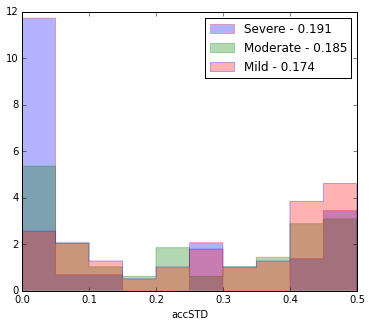

In [82]:
accPeaks = np.array(accPeaks)
selModerate = np.where(DF.Stress == 'moderate')
selSevere = np.where(DF.Stress == 'severe')
selMild = np.where(DF.Stress == 'mild')  

figure(figsize=(6, 5))
ax = subplot(111)
mod, sev, mild = (accPeaks[selModerate], accPeaks[selSevere], accPeaks[selMild])
n, bins, patches = ax.hist([mild, mod, sev], histtype='step', normed=1, fill=True, alpha=0.3,
        label=['Mild - '+str(round(std(mild),3)), 
               'Moderate - '+str(round(std(mod),3)),
               'Severe - '+str(round(std(sev),3))])
ax.set_xlabel('accSTD')
ax.legend()

### Creating Dataframe with ALL the metrics

In [32]:
IDtmp, slopetmp, labeltmp = [], [], []
for ii in np.arange(len(DF)):
    IDtmp.append(DF.ix[ii].ID)
    slopetmp.append(DF.ix[ii].Slope)
    labeltmp.append(DF.ix[ii].Stress)

dicMetrics = {'ID': pd.Series(IDtmp), 
              'slope': pd.Series(slopetmp), 'label': pd.Series(labeltmp),
              'Gini_t': pd.Series(GiniP_trended), 'Gini_dt': pd.Series(GiniP_detrended), 
              'Gini_diff': pd.Series(np.array(GiniP_trended)-np.array(GiniP_detrended)),
              'Entropy_tot': pd.Series(entropy_total), 'Entropy_sleep': pd.Series(entropy_sleep),
              'SVD2': pd.Series(SVD_2), 'SVD3': pd.Series(SVD_3), 
              'SVD5': pd.Series(SVD_5), 'SVD10': pd.Series(SVD_10), 
              'SVD15': pd.Series(SVD_15), 'SVD20': pd.Series(SVD_20), 
              'SVD25': pd.Series(SVD_25), 'SVD30': pd.Series(SVD_30), 
              'Petrosian': pd.Series(Petrosian), 'Hjorth': pd.Series(Hjorth), 
              'Hurst': pd.Series(hurstExponent), 'DFA_dt': pd.Series(DFA_sel_detrended), 
              'H_mobility': pd.Series(H_mobility), 'H_complexity': pd.Series(H_complexity), 
              'FT_std': pd.Series(FT_std), 'std_DT': pd.Series(std_detrended), 
              'average_HB': pd.Series(average_HB), 'median_HB': pd.Series(median_HB), 
              'sleepingTime': pd.Series(sleepingTime)
             }
              
df_metrics = pd.DataFrame(dicMetrics)


# Save DF as as .csv
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
write_csv = robjects.r('write.csv')
write_csv(df_metrics,'metrics.csv')

rpy2.rinterface.NULL

#### Clustering

In [ ]:
# Using Gini detrended, Gini trended, Std, entropy, slope of fit as metrics

#### Decision tree

#### Ideas
- using the difference between the trended and the de-trended sleeping region Gini as a measure of large scale inequalities